<h1>Indian Cities AQI Data Analysis and Prediction
</h1>

<h3> Data Analysis and Visualizations </h3>

In [1]:
import kagglehub
import os
import xml.etree.ElementTree as ET
import csv

# Download the dataset
path = kagglehub.dataset_download("bhadramohit/india-air-quality-index2024-dataset")
print("Path to dataset files:", path)

# Construct the full path to the XML file
xml_file_path = os.path.join(path, "data_aqi_cpcb.xml")

# Check if the XML file exists
if not os.path.exists(xml_file_path):
    raise FileNotFoundError(f"XML file not found at {xml_file_path}")

# Parses the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Opens a CSV file for writing
with open('AqIndex.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)

    # Writes the header
    header = [
        "Country", "State", "City", "Station", "Latitude", "Longitude",
        'Last Update', "Pollutant", "Min", "Max", "Avg", "AQI", "Predominant Parameter"
    ]
    writer.writerow(header)

    # Iterates through the XML structure and writes rows
    for country in root.findall('Country'):
        country_id = country.get('id')
        for state in country.findall('State'):
            state_id = state.get('id')
            for city in state.findall('City'):
                city_id = city.get('id')
                for station in city.findall('Station'):
                    station_id = station.get('id')
                    latitude = station.get('latitude')
                    longitude = station.get('longitude')
                    last_update = station.get('lastupdate')

                    # Pollutant details
                    for pollutant in station.findall('Pollutant_Index'):
                        pollutant_id = pollutant.get('id')
                        min_val = pollutant.get('Min')
                        max_val = pollutant.get('Max')
                        avg_val = pollutant.get('Avg')

                        # Defaults AQI details to empty
                        aqi_value = ""
                        predominant_param = ""

                        # Checks for AQI details
                        aqi = station.find('Air_Quality_Index')
                        if aqi is not None:
                            aqi_value = aqi.get('Value')
                            predominant_param = aqi.get('Predominant_Parameter')

                        # Writes a row to the CSV
                        writer.writerow([
                            country_id,
                            state_id,
                            city_id,
                            station_id,
                            latitude,
                            longitude,
                            last_update,
                            pollutant_id,
                            min_val,
                            max_val,
                            avg_val,
                            aqi_value,
                            predominant_param
                        ])

print("XML data has been successfully converted to CSV!")


100%|██████████| 40.9k/40.9k [00:00<00:00, 43.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/bhadramohit/india-air-quality-index2024-dataset/versions/1
XML data has been successfully converted to CSV!


Once the data is converted to CSV format, we can use Pandas and Seaborn to visualize it.

In [ ]:
import pandas as pd

aqi_data = pd.read_csv('AqIndex.csv')
aqi_data.head()

Country           State       City                         Station  \
0   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
1   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
2   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
3   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
4   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   

    Latitude  Longitude          Last Update Pollutant  Min  Max  Avg  AQI  \
0  16.515083  80.518167  20-11-2023 12:00:00     PM2.5  NaN  NaN  NaN  NaN   
1  16.515083  80.518167  20-11-2023 12:00:00      PM10  NaN  NaN  NaN  NaN   
2  16.515083  80.518167  20-11-2023 12:00:00       SO2  NaN  NaN  NaN  NaN   
3  16.515083  80.518167  20-11-2023 12:00:00        CO  NaN  NaN  NaN  NaN   
4  16.515083  80.518167  20-11-2023 12:00:00     OZONE  NaN  NaN  NaN  NaN   

  Predominant Parameter  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

Now, we will start by creating a bar chart with the average AQI per state. This is done by averaging the AQIs of all the cities in the state and plotting that value with error whiskers

<ipython-input-4-1088df2d9608>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aqi_data['State'], y=aqi_data['AQI'], palette='viridis')


Text(0, 0.5, 'Average AQI')

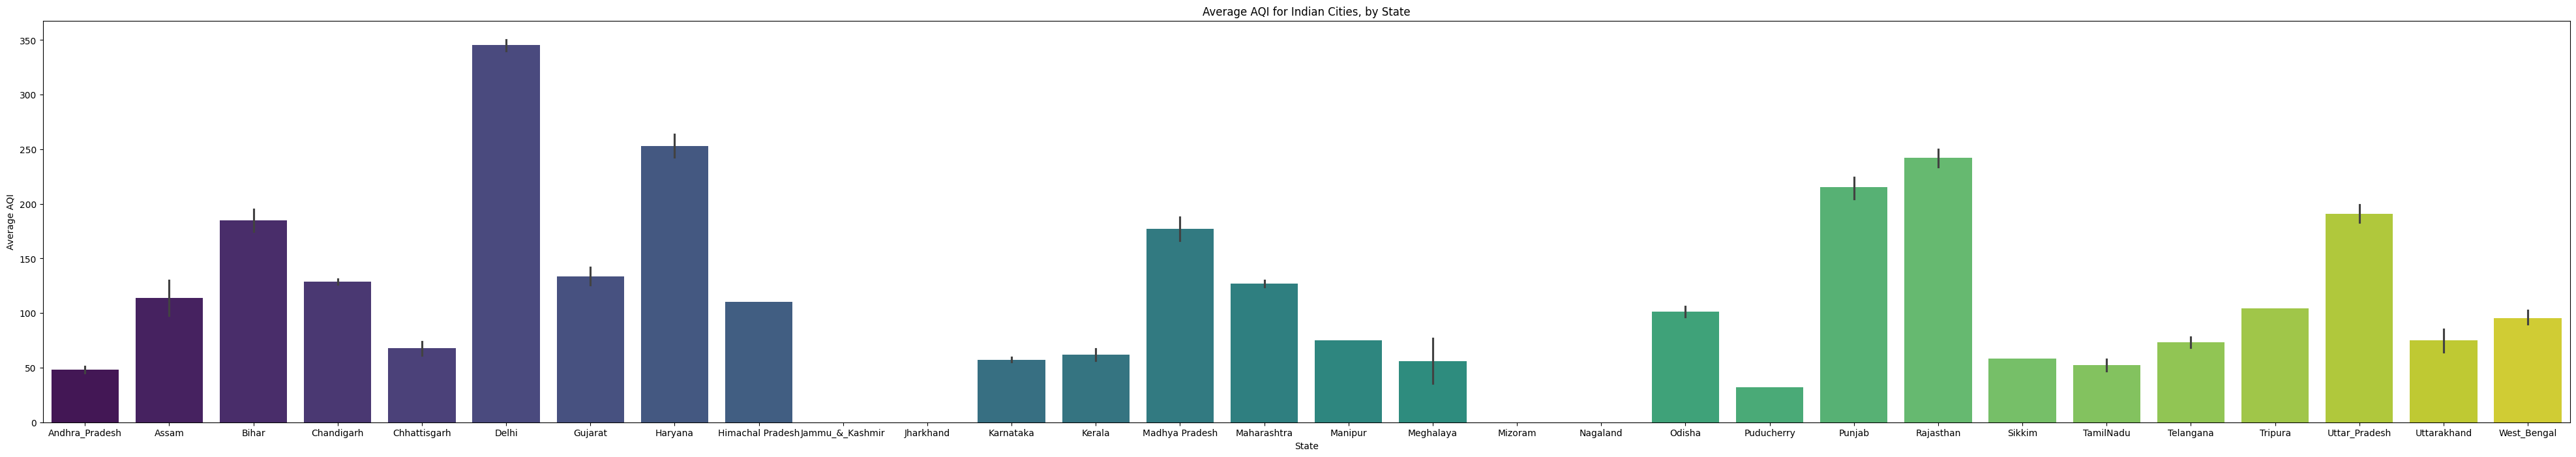

In [ ]:
from ast import increment_lineno
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(50, 8))
# Add title
plt.title("Average AQI for Indian Cities, by State")

sns.barplot(x=aqi_data['State'], y=aqi_data['AQI'], palette='viridis')

# Add label for vertical axis
plt.ylabel("Average AQI")

<b> Analysis of the Bar Chart: </b>
  1. <b>Overview:</b>


*   The plot shows the Average Air Quality Index (AQI) for various states in India.
*   The x-axis represents different Indian states, and the y-axis shows the Average AQI.
*   Different colors are used to differentiate between states, with error bars indicating some level of variance or uncertainity in AQI values.

2. <b>Key Observations:</b>


*   Delhi has the highest AQI, suggesting severe air pollution levels. This is consistent with real-world data where Delhi often ranks as one of the most polluted cities in the world.
*   States like Punjab, Rajasthan, and Haryana also have relatively high AQI values, indicating poor air quality.
*   On the other end, states like J&K, Jharkhand, and Mizoram show much virtually 0 AQI values, implying better air quality in those regions, or lack of data








Now we will create a Heatmap of the Amount of Carbon Monoxide (a toxic gas) in each city.

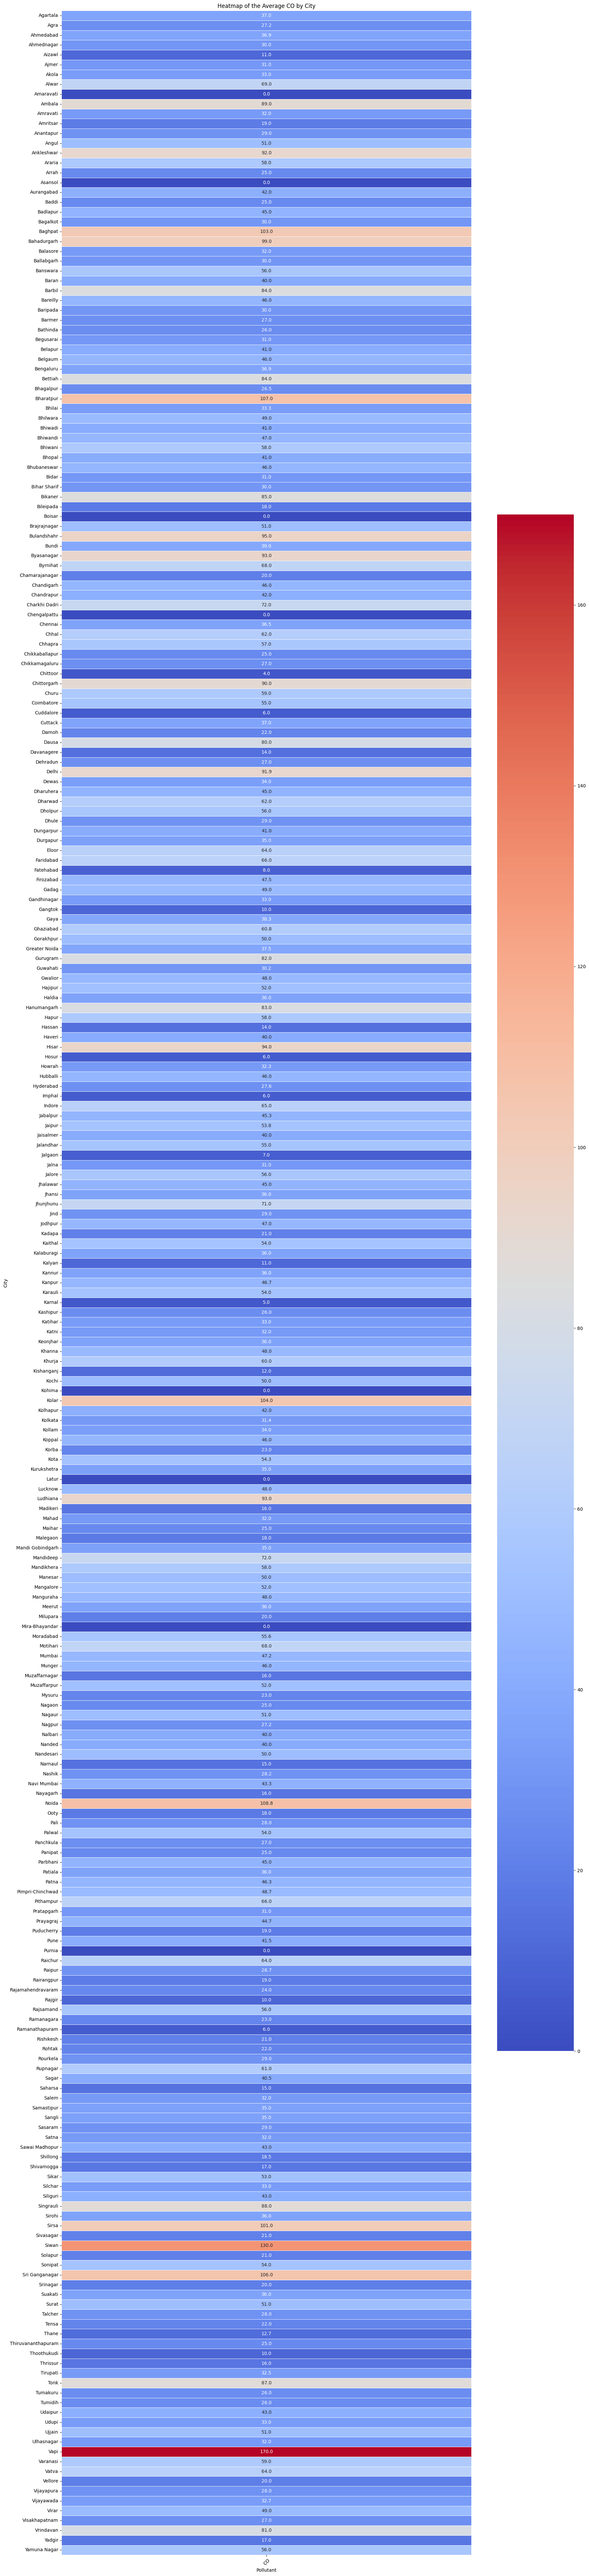

In [ ]:
# Step 1: Data Preprocessing
# Handling the missing values by filling NaN with 0
aqi_data.fillna(0, inplace=True)

filtered_data = aqi_data[aqi_data['Pollutant'].isin(['CO'])]

# Step 2: Create a Pivot Table
# We are interested in avg AQI for each city and pollutant, so we will pivot the data
pivot_table = filtered_data.pivot_table(
    index='City',
    columns='Pollutant',
    values='Avg',
    aggfunc='mean'
)

# Fill any remaining NaN values in the pivot table with 0
pivot_table.fillna(0, inplace=True)

# Step 3: Plotting the heatmap
plt.figure(figsize=(20,100))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5)

# Adding Titles and Labels
plt.title('Heatmap of the Average CO by City')
plt.xlabel('Pollutant')
plt.ylabel('City')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Display the heatmap
plt.show()

This data is huge, so we can divert our focus to the cities in the states with the worst AQI as indicated by the bar chart (Delhi, Punjab, Rajasthan, Haryana and Madhya Pradesh)

Let's create a similar heatmap as above with PM2.5 and PM10


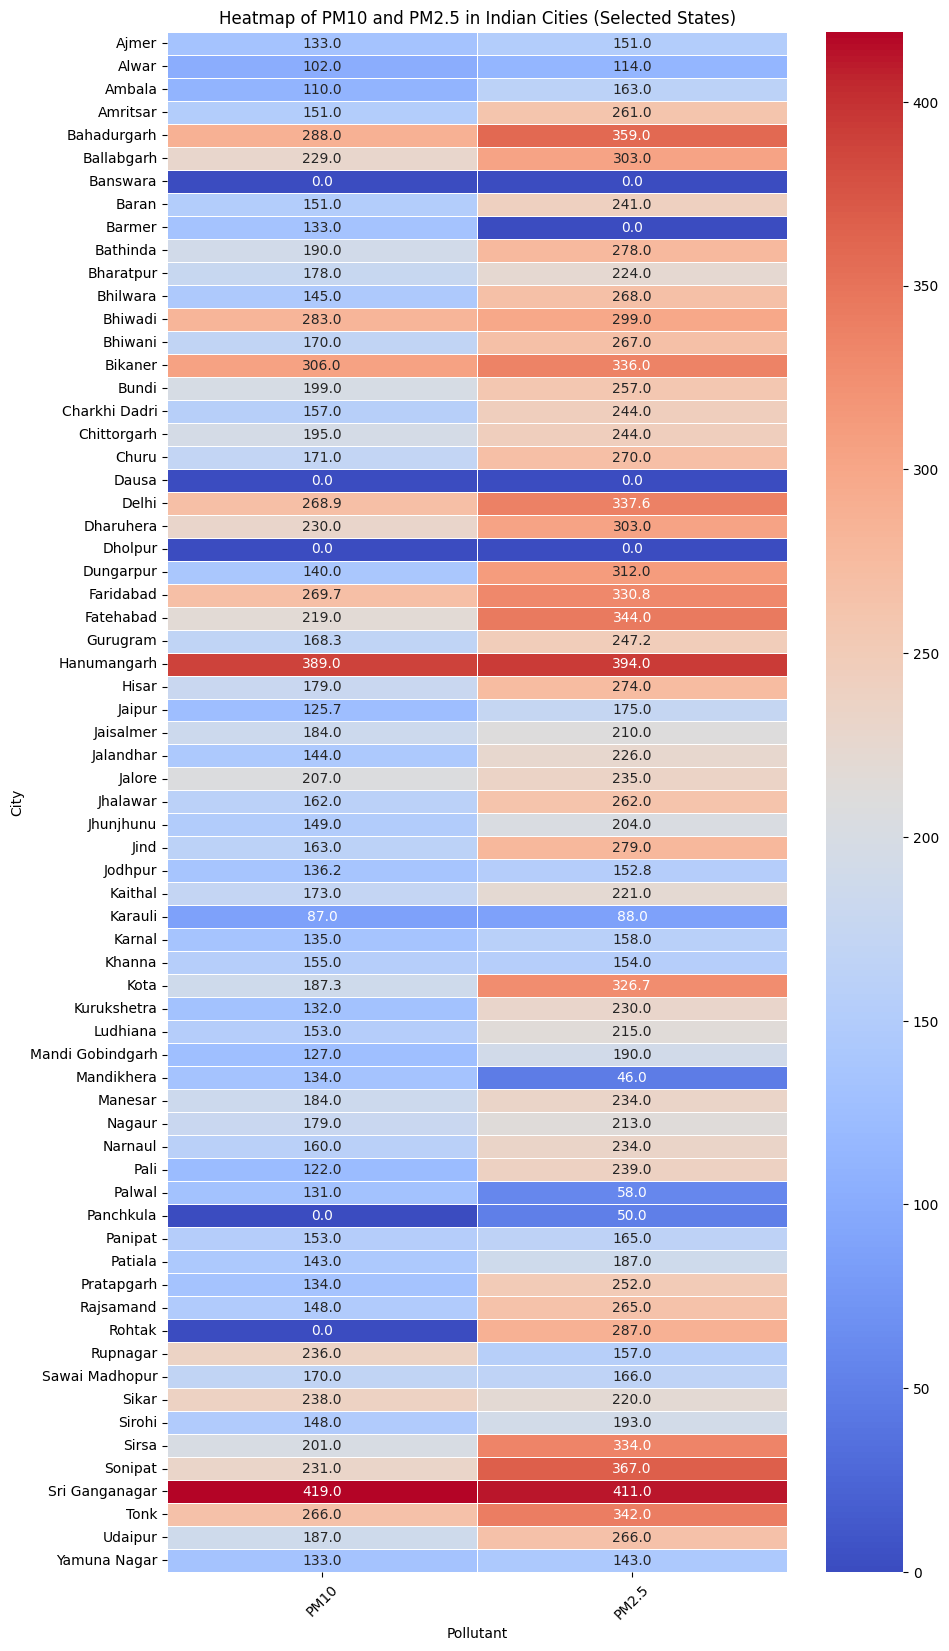

In [ ]:
# Step 1: Data Preprocessing
# Filter data for specific states
states_of_interest = ['Delhi', 'Haryana', 'Madhya_Pradesh', 'Punjab', 'Rajasthan']
filtered_data = aqi_data[aqi_data['State'].isin(states_of_interest)]
filtered_data = filtered_data[filtered_data['Pollutant'].isin(['PM10', 'PM2.5'])]

# Handle missing values by filling NaN with 0
filtered_data.fillna(0, inplace=True)

# Step 2; Create a Pivot Table
# We are interested in Avg AQI for each city and pollutant, so let's pivot the data
pivot_table = filtered_data.pivot_table(
    index='City',
    columns='Pollutant',
    values='Avg',
    aggfunc='mean'
)

# Fill any remaining NaN values in the pivot table with 0
pivot_table.fillna(0, inplace=True)

# Step 3: Plotting the Heatmap
plt.figure(figsize=(10,20))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".1f", linewidth=0.5)

# Adding Titles and Labels
plt.title('Heatmap of PM10 and PM2.5 in Indian Cities (Selected States)')
plt.xlabel('Pollutant')
plt.ylabel('City')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Display the heatmap
plt.show()

Creating a Scatter Plot which plots the concentrations of PM2.5 and PM10 against AQI, to see if these factors affect the AQI.

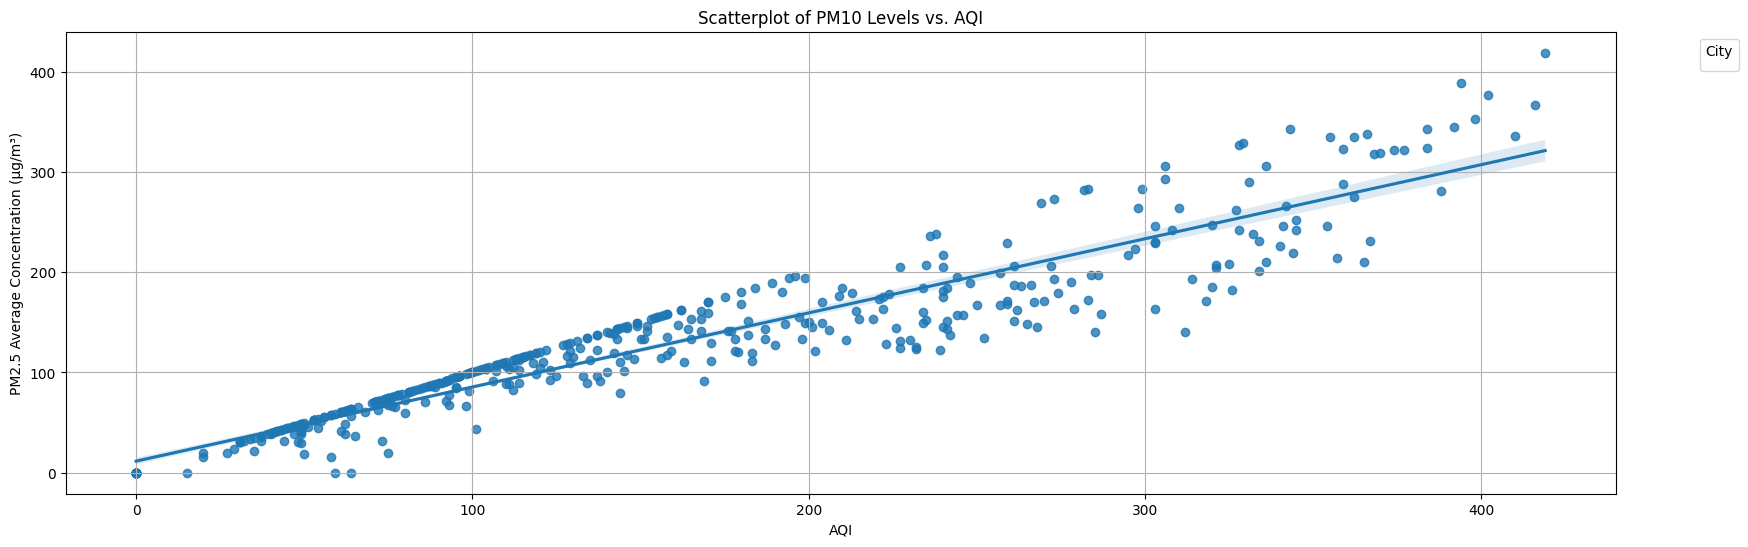

In [ ]:
# Step 1: Data Preprocessing
# Filter the dataset to include only rows where the Pollutant is 'PM2.5'
pm10_df = aqi_data[aqi_data['Pollutant'] == 'PM10']

# Handle missing values by dropping rows with NaN in 'Avg' or 'AQI' columns
pm10_df = pm10_df.dropna(subset=['Avg', 'AQI'])

# Step 2: Create a Scatterplot
plt.figure(figsize=(20,6))
sns.regplot(x=pm10_df['AQI'], y=pm10_df['Avg'])

# Adding Titles and Labels
plt.title('Scatterplot of PM10 Levels vs. AQI')
plt.xlabel('AQI')
plt.ylabel('PM2.5 Average Concentration (µg/m³)')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

<b>Conclusion</b>
As we can see, AQI is almost directly correlated to the concentrations of PM2.5 and PM10

Furthermore, we can see that the most polluted states are Delhi, Punjab, Rajasthan, Haryana, Madhya Pradesh


<h3> AQI Prediction Model </h3>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
df=pd.read_csv('AqIndex.csv')
print(df.head())
print(df.isnull().sum())
print(df.info())

  Country           State       City                         Station  \
0   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
1   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
2   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
3   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
4   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   

    Latitude  Longitude          Last Update Pollutant  Min  Max  Avg  AQI  \
0  16.515083  80.518167  20-11-2023 12:00:00     PM2.5  NaN  NaN  NaN  NaN   
1  16.515083  80.518167  20-11-2023 12:00:00      PM10  NaN  NaN  NaN  NaN   
2  16.515083  80.518167  20-11-2023 12:00:00       SO2  NaN  NaN  NaN  NaN   
3  16.515083  80.518167  20-11-2023 12:00:00        CO  NaN  NaN  NaN  NaN   
4  16.515083  80.518167  20-11-2023 12:00:00     OZONE  NaN  NaN  NaN  NaN   

  Predominant Parameter  
0                   NaN  
1                   NaN  
2                   

In [5]:
df['Min'].fillna(df['Min'].mean(), inplace=True)
df['Max'].fillna(df['Max'].mean(), inplace=True)
df['Avg'].fillna(df['Avg'].mean(), inplace=True)
df['AQI'].fillna(df['AQI'].mean(), inplace=True)
df['Predominant Parameter'].fillna('Unknown', inplace=True)

In [ ]:
print(df.isnull().sum())

Country                  0
State                    0
City                     0
Station                  0
Latitude                 0
Longitude                0
Last Update              0
Pollutant                0
Min                      0
Max                      0
Avg                      0
AQI                      0
Predominant Parameter    0
dtype: int64


### <b>EDA</b>

In [ ]:
print(df.describe())
print(df['Country'].value_counts())
print(df['State'].value_counts())
print(df['City'].value_counts())
print(df['Pollutant'].value_counts())

          Latitude    Longitude          Min          Max          Avg  \
count  3285.000000  3285.000000  3285.000000  3285.000000  3285.000000   
mean     22.795529    78.455119    34.095269   100.117455    60.659054   
std       5.416659     4.800781    44.156667   110.883612    73.399435   
min       8.514909    70.909168     1.000000     1.000000     1.000000   
25%      19.063214    75.467934     6.000000    21.000000    13.000000   
50%      23.500160    77.296291    18.000000    67.000000    35.000000   
75%      27.213494    80.262850    39.000000   119.000000    71.000000   
max      34.066206    94.636574   357.000000   500.000000   419.000000   

               AQI  
count  3285.000000  
mean    162.007890  
std      95.314515  
min      15.000000  
25%      87.000000  
50%     145.000000  
75%     227.000000  
max     419.000000  
Country
India    3285
Name: count, dtype: int64
State
Maharashtra         569
Uttar_Pradesh       359
Rajasthan           313
Karnataka         

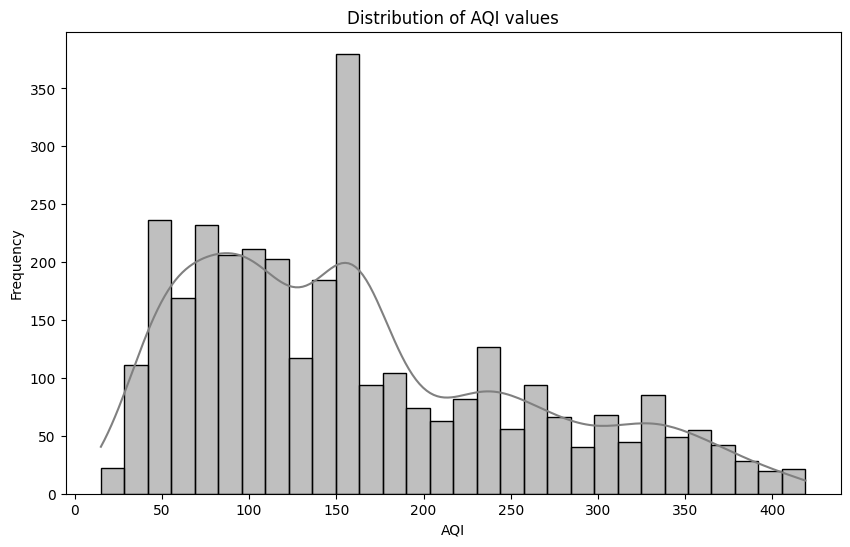

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['AQI'], bins=30, kde=True, color='grey')
plt.title('Distribution of AQI values')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()

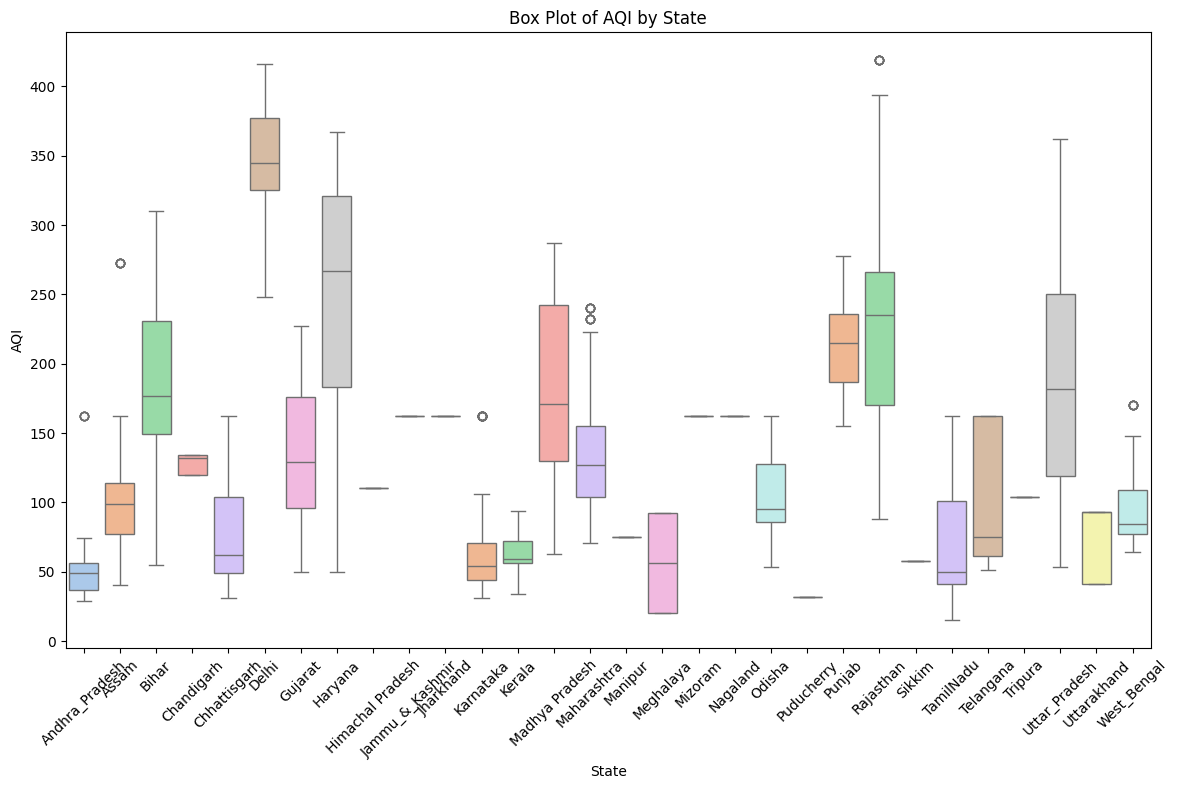

In [ ]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='State', y='AQI', data=df, palette='pastel')
plt.title('Box Plot of AQI by State')
plt.xlabel('State')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.show()

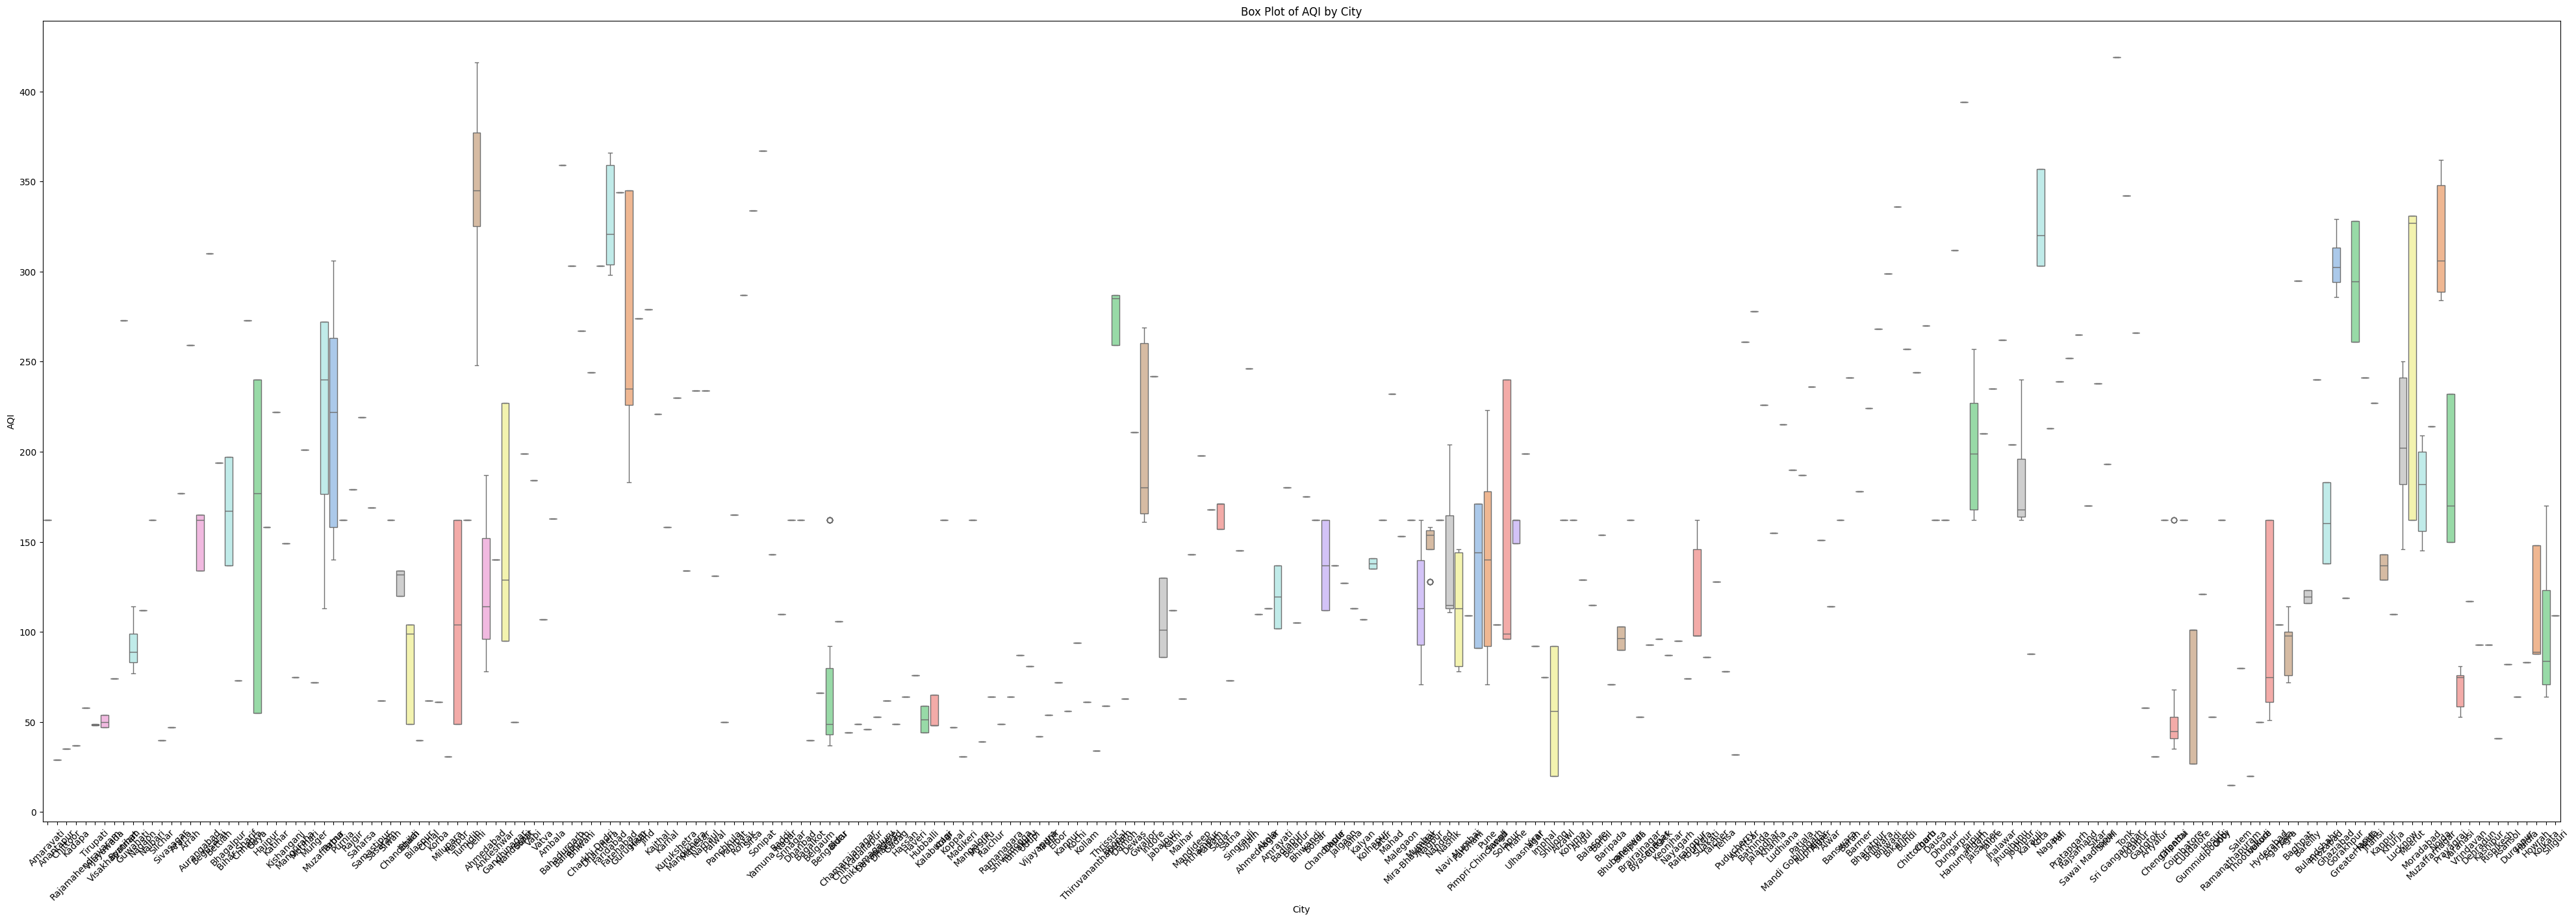

In [ ]:
plt.figure(figsize=(50, 16))
sns.boxplot(x='City', y='AQI', data=df, palette='pastel')
plt.title('Box Plot of AQI by City')
plt.xlabel('City')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.show()

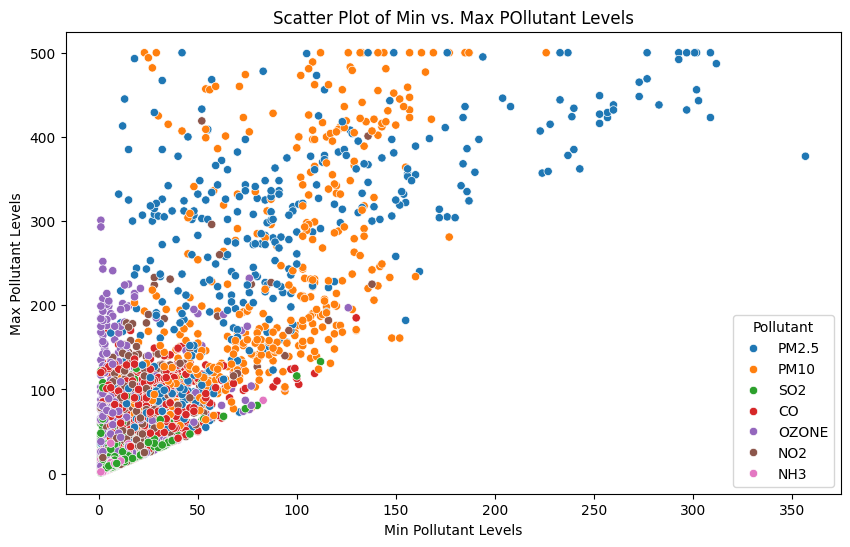

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Min', y='Max', hue='Pollutant', data=df)
plt.title('Scatter Plot of Min vs. Max POllutant Levels')
plt.xlabel('Min Pollutant Levels')
plt.ylabel('Max Pollutant Levels')
plt.show()

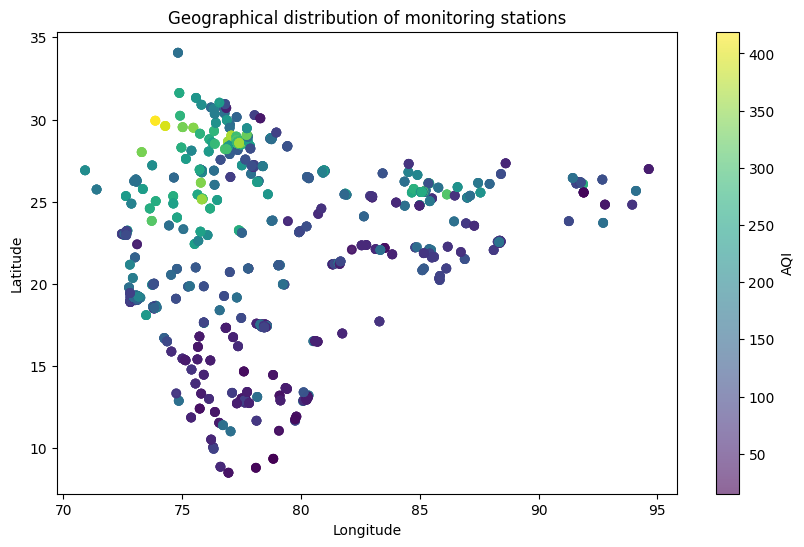

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Longitude'], df['Latitude'], c=df['AQI'], cmap='viridis', alpha=0.6)
plt.colorbar(label='AQI')
plt.title('Geographical distribution of monitoring stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

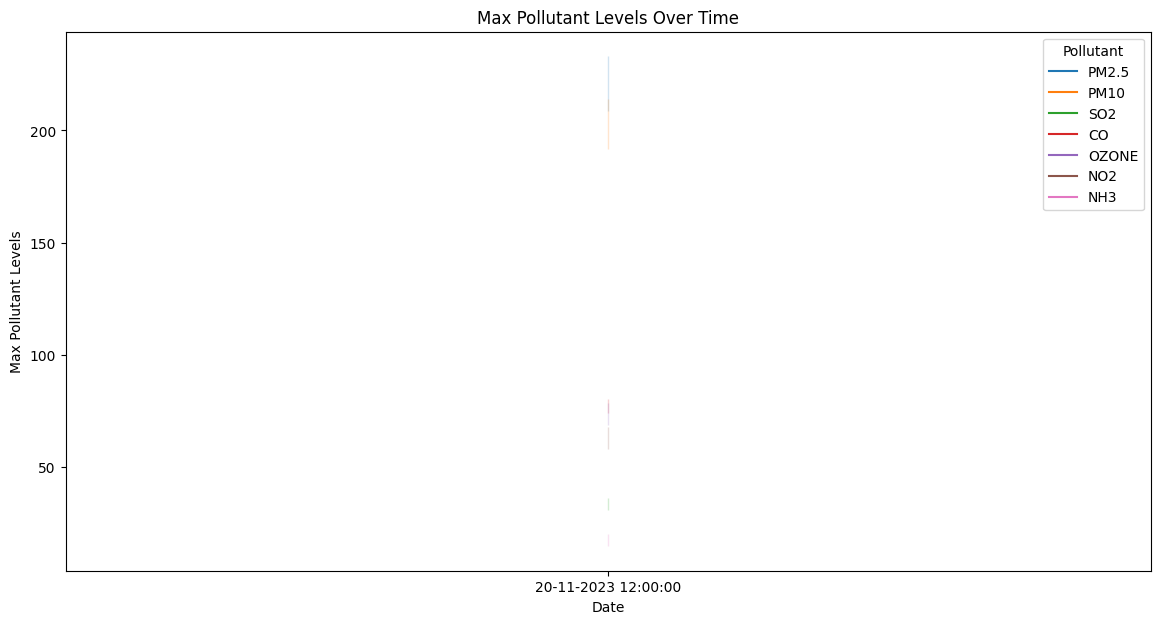

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Last Update', y='Max', hue='Pollutant', data=df)
plt.title('Max Pollutant Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Max Pollutant Levels')
plt.show()

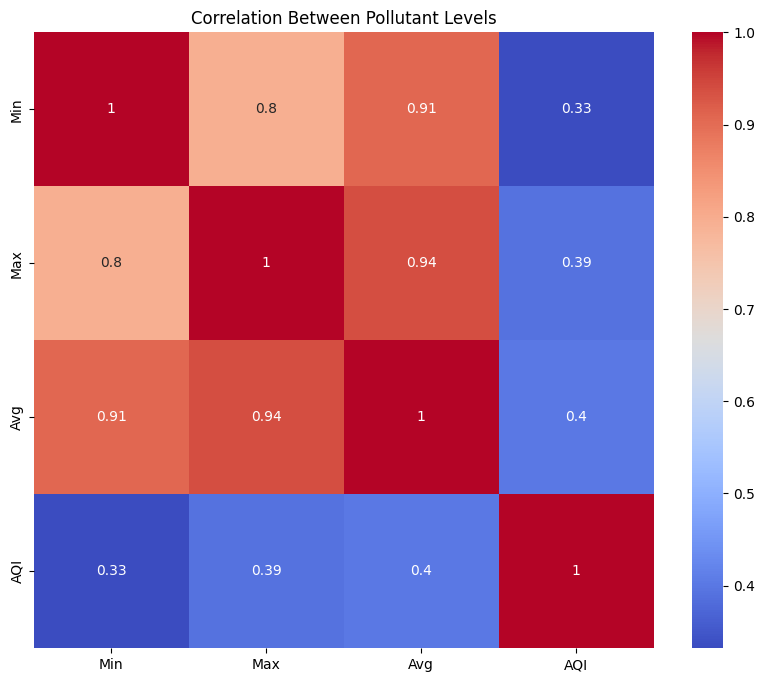

In [ ]:
plt.figure(figsize=(10,8))
correlation = df[['Min', 'Max', 'Avg', 'AQI']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Between Pollutant Levels')
plt.show()

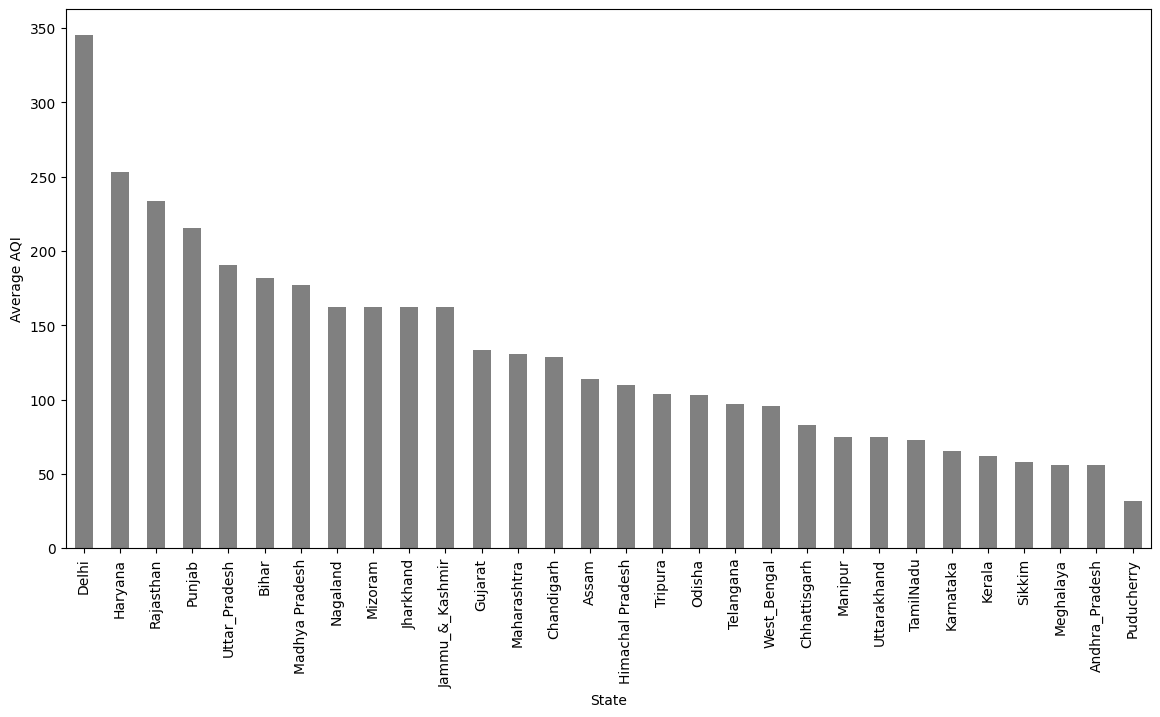

In [ ]:
plt.figure(figsize=(14,7))
state_aqi = df.groupby('State')['AQI'].mean().sort_values(ascending=False)
state_aqi.plot(kind='bar', color='grey')
plt.xlabel('State')
plt.ylabel('Average AQI')
plt.show()

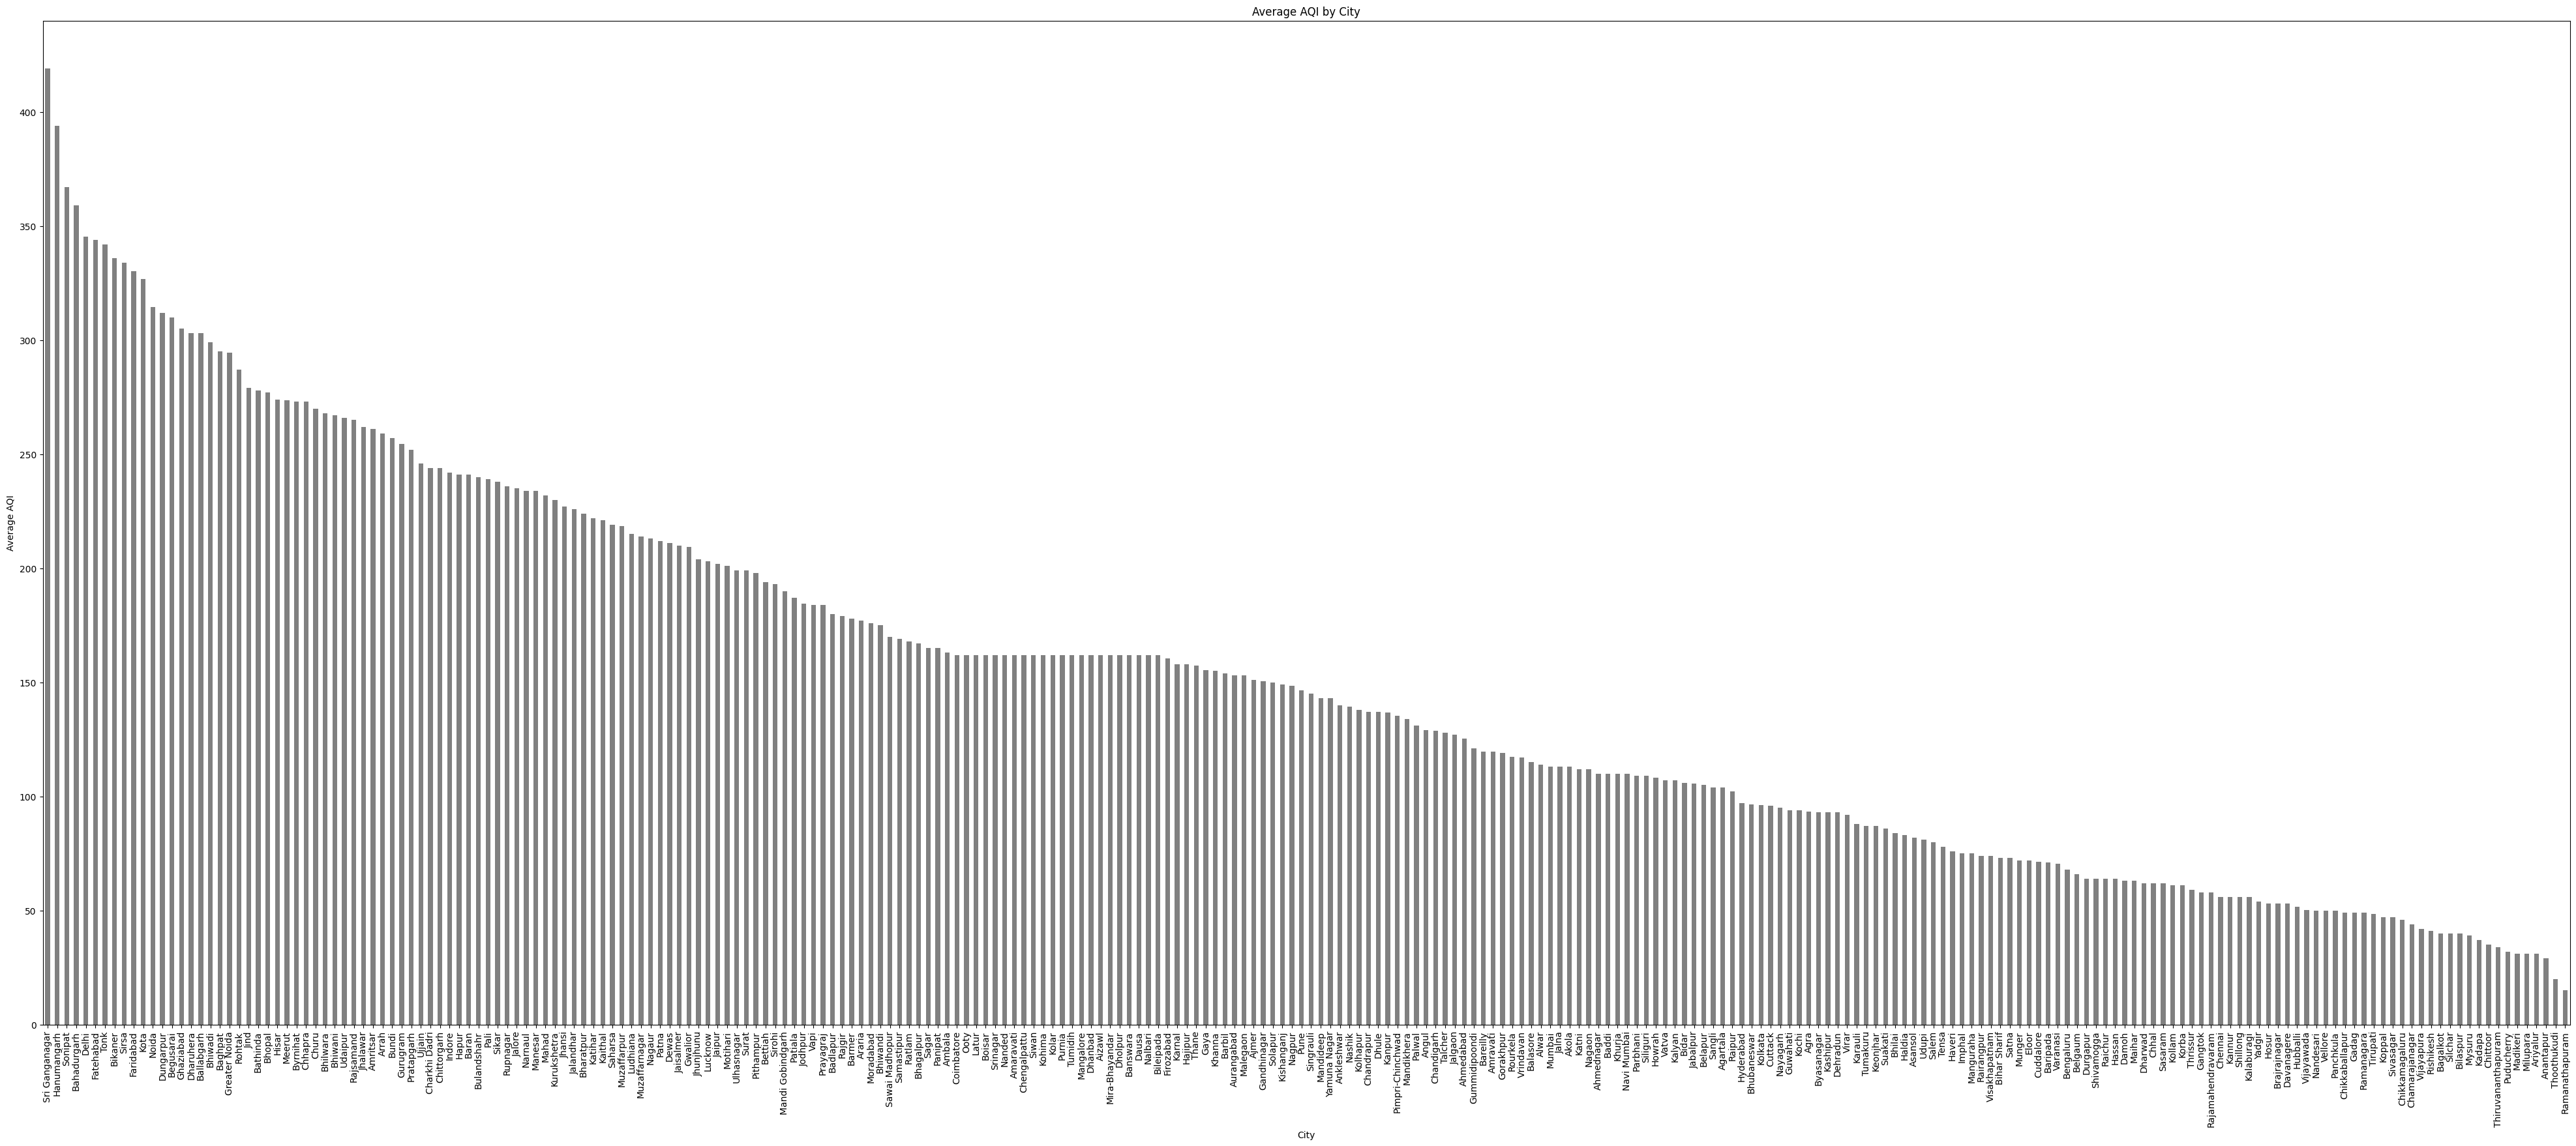

In [ ]:
plt.figure(figsize=(50,20))
city_aqi = df.groupby('City')['AQI'].mean().sort_values(ascending=False)
city_aqi.plot(kind='bar', color='grey')
plt.title('Average AQI by City')
plt.xlabel('City')
plt.ylabel('Average AQI')
plt.show()

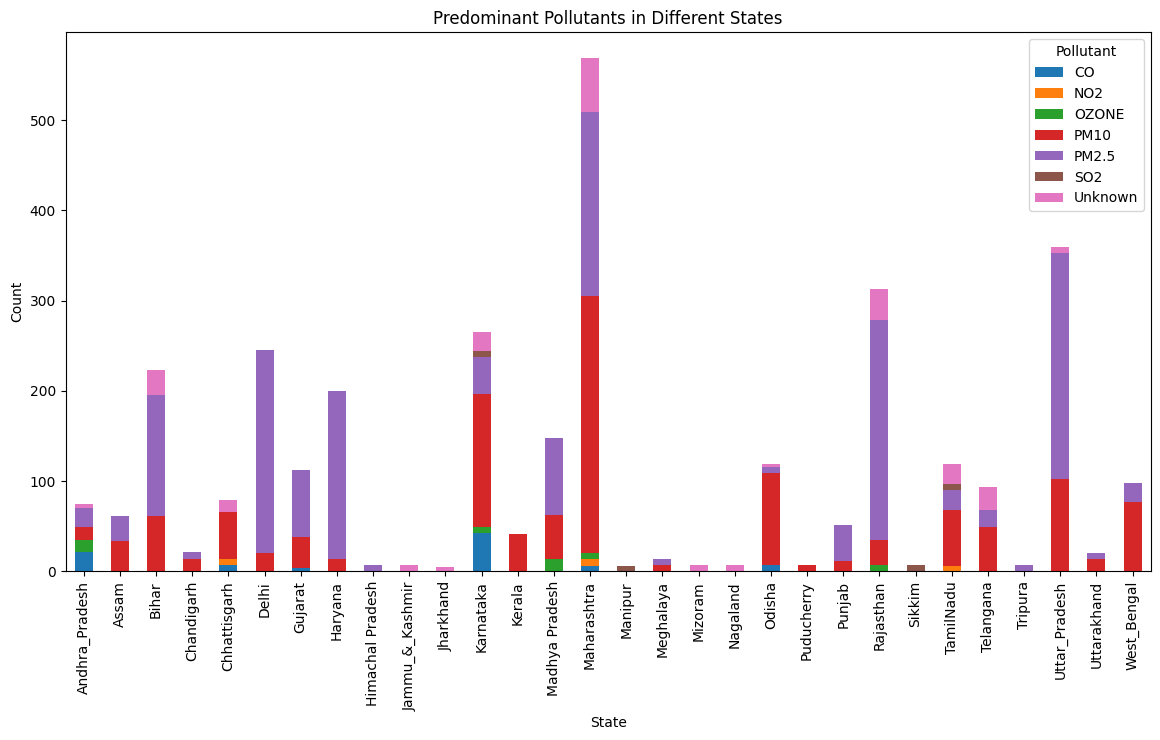

In [ ]:
predominant_pollutants = df.groupby(['State', 'Predominant Parameter']).size().unstack().fillna(0)
predominant_pollutants.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Predominant Pollutants in Different States')
plt.xlabel('State')
plt.ylabel('Count')
plt.legend(title='Pollutant')
plt.show()

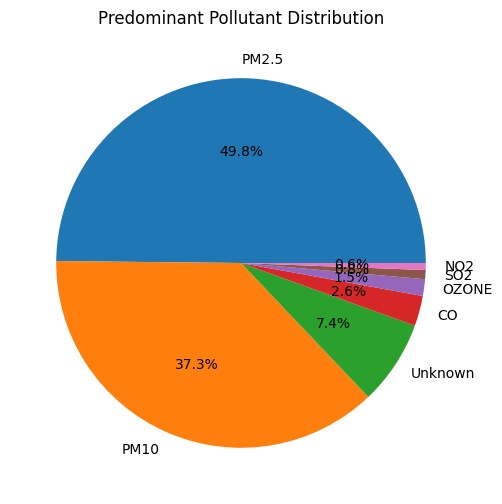

In [ ]:
predominant_pollutants = df['Predominant Parameter'].value_counts()
plt.figure(figsize=(10, 6))
predominant_pollutants.plot(kind='pie', autopct='%1.1f%%')
plt.title('Predominant Pollutant Distribution')
plt.ylabel('')
plt.show()

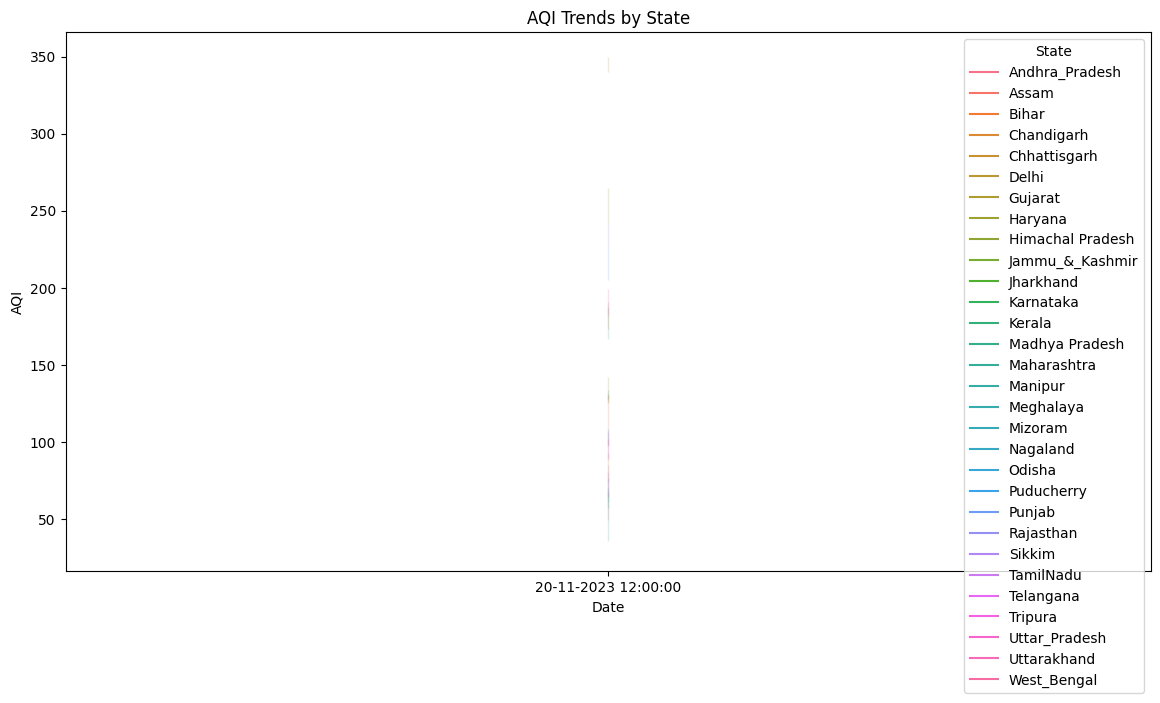

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Last Update', y='AQI', hue='State', data=df)
plt.title('AQI Trends by State')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

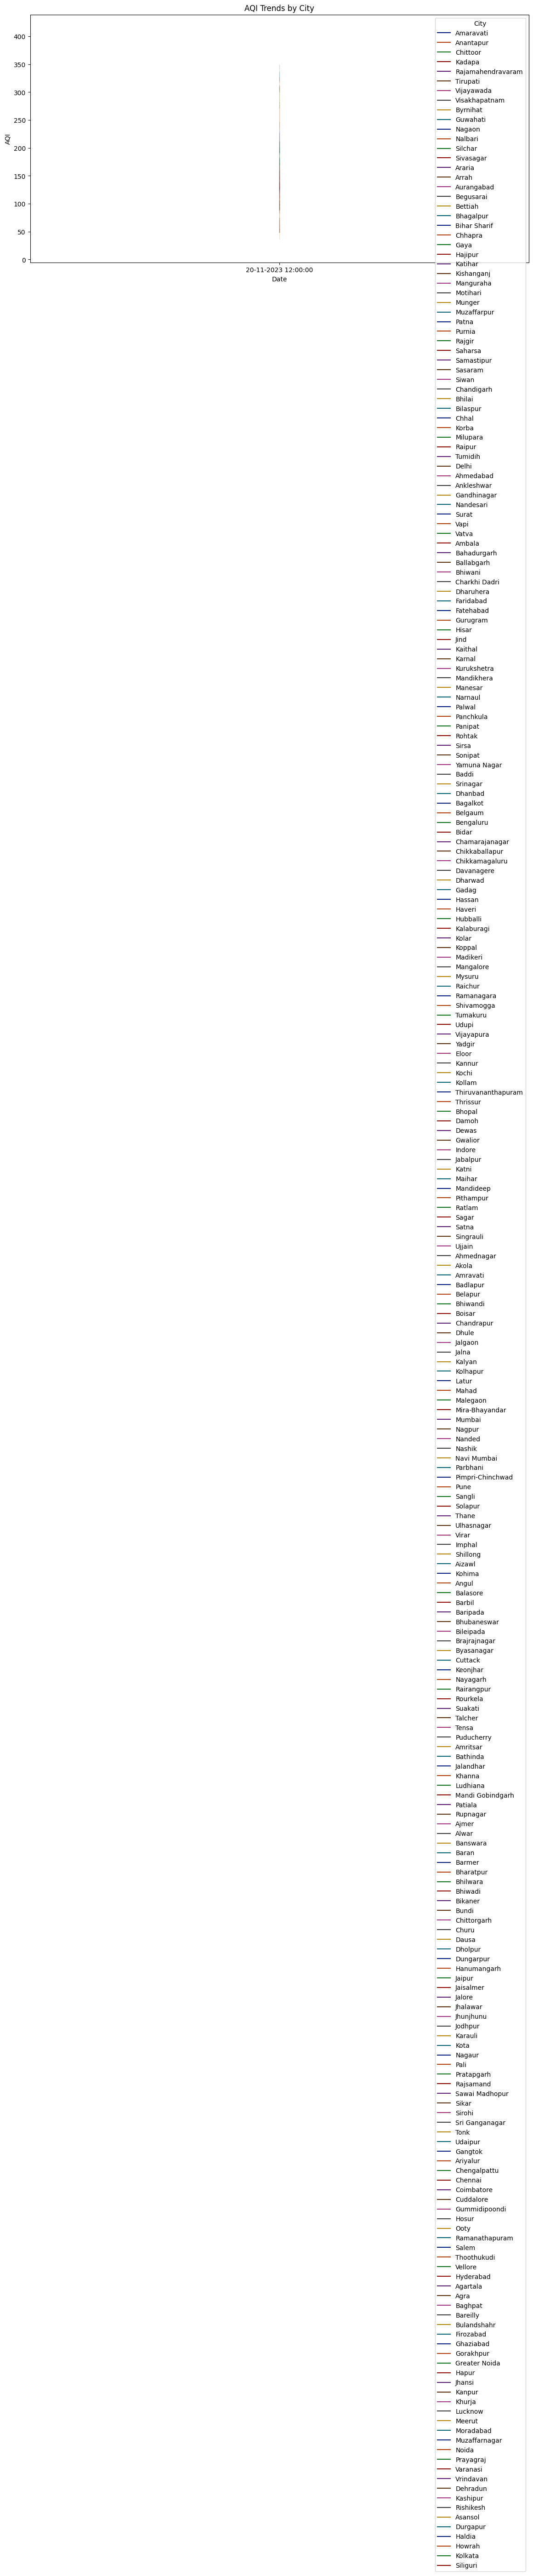

In [ ]:
plt.figure(figsize=(14, 7))
dark_palette = sns.color_palette("dark", n_colors=len(df['City'].unique()))
sns.lineplot(x='Last Update', y='AQI', hue='City', data=df, palette=dark_palette)
plt.title('AQI Trends by City')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.show

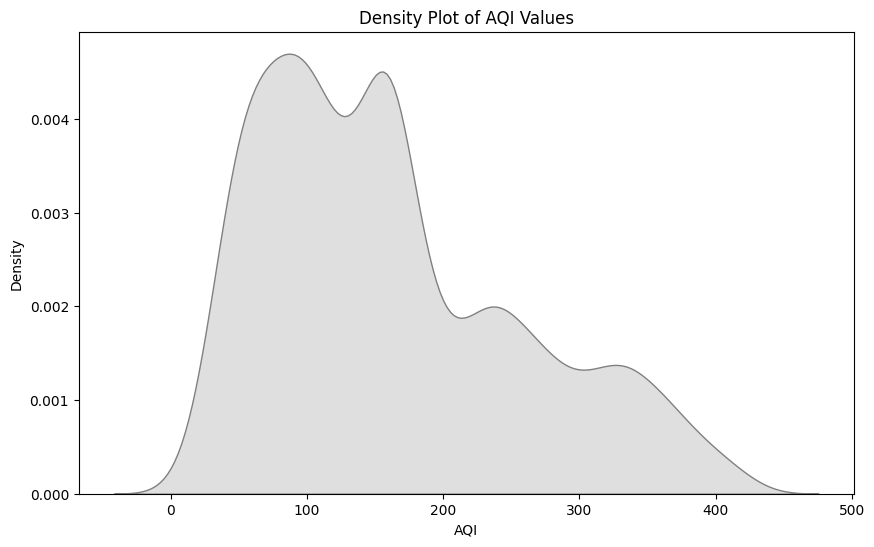

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(df['AQI'], shade=True, color='grey')
plt.title('Density Plot of AQI Values')
plt.xlabel('AQI')
plt.ylabel('Density')
plt.show()

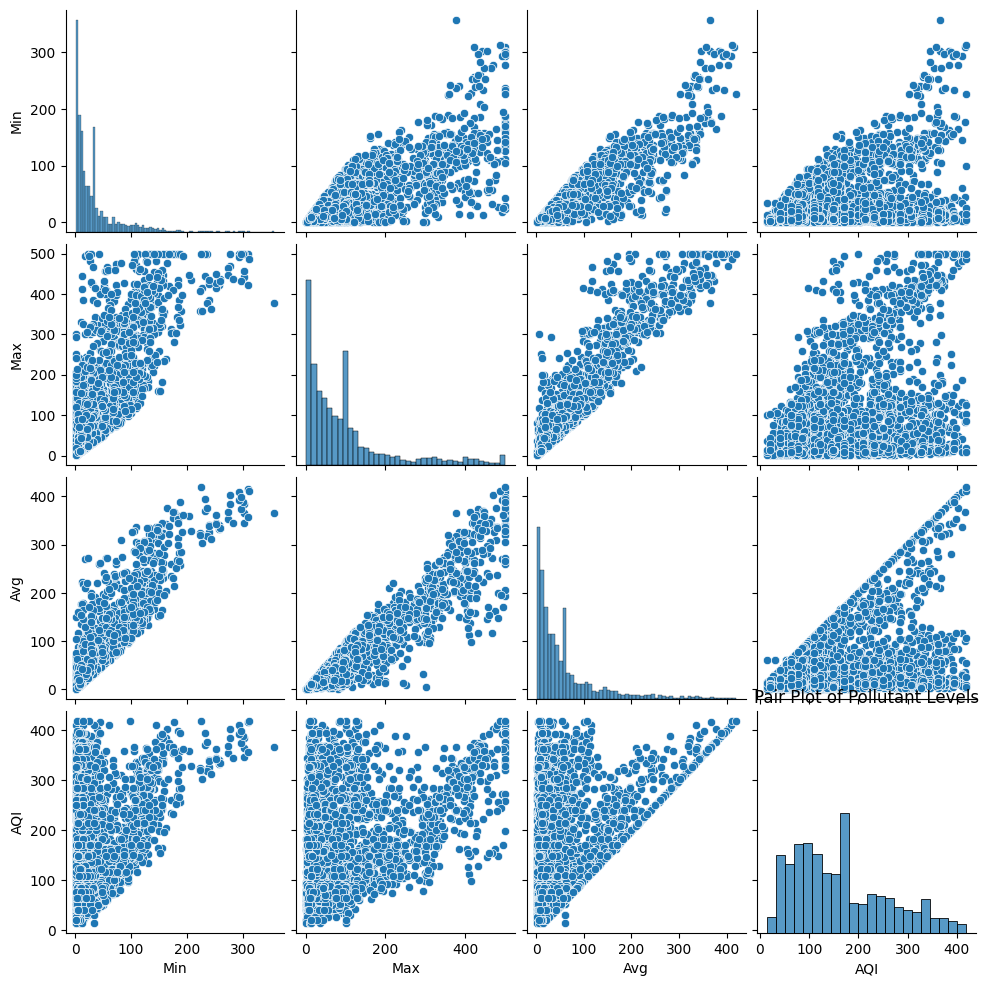

In [ ]:
sns.pairplot(df[['Min', 'Max', 'Avg', 'AQI']], palette='grey')
plt.title('Pair Plot of Pollutant Levels')
plt.show()

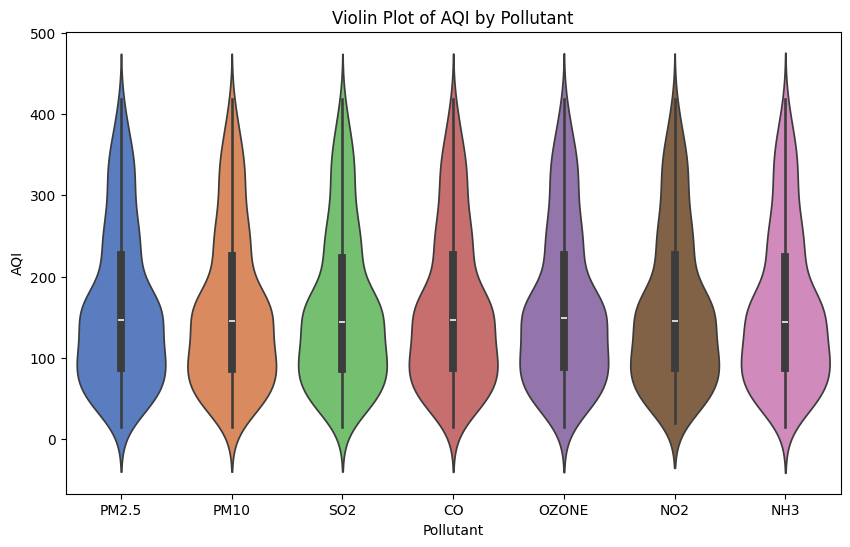

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Pollutant', y='AQI', data=df, palette='muted')
plt.title('Violin Plot of AQI by Pollutant')
plt.xlabel('Pollutant')
plt.ylabel('AQI')
plt.show()


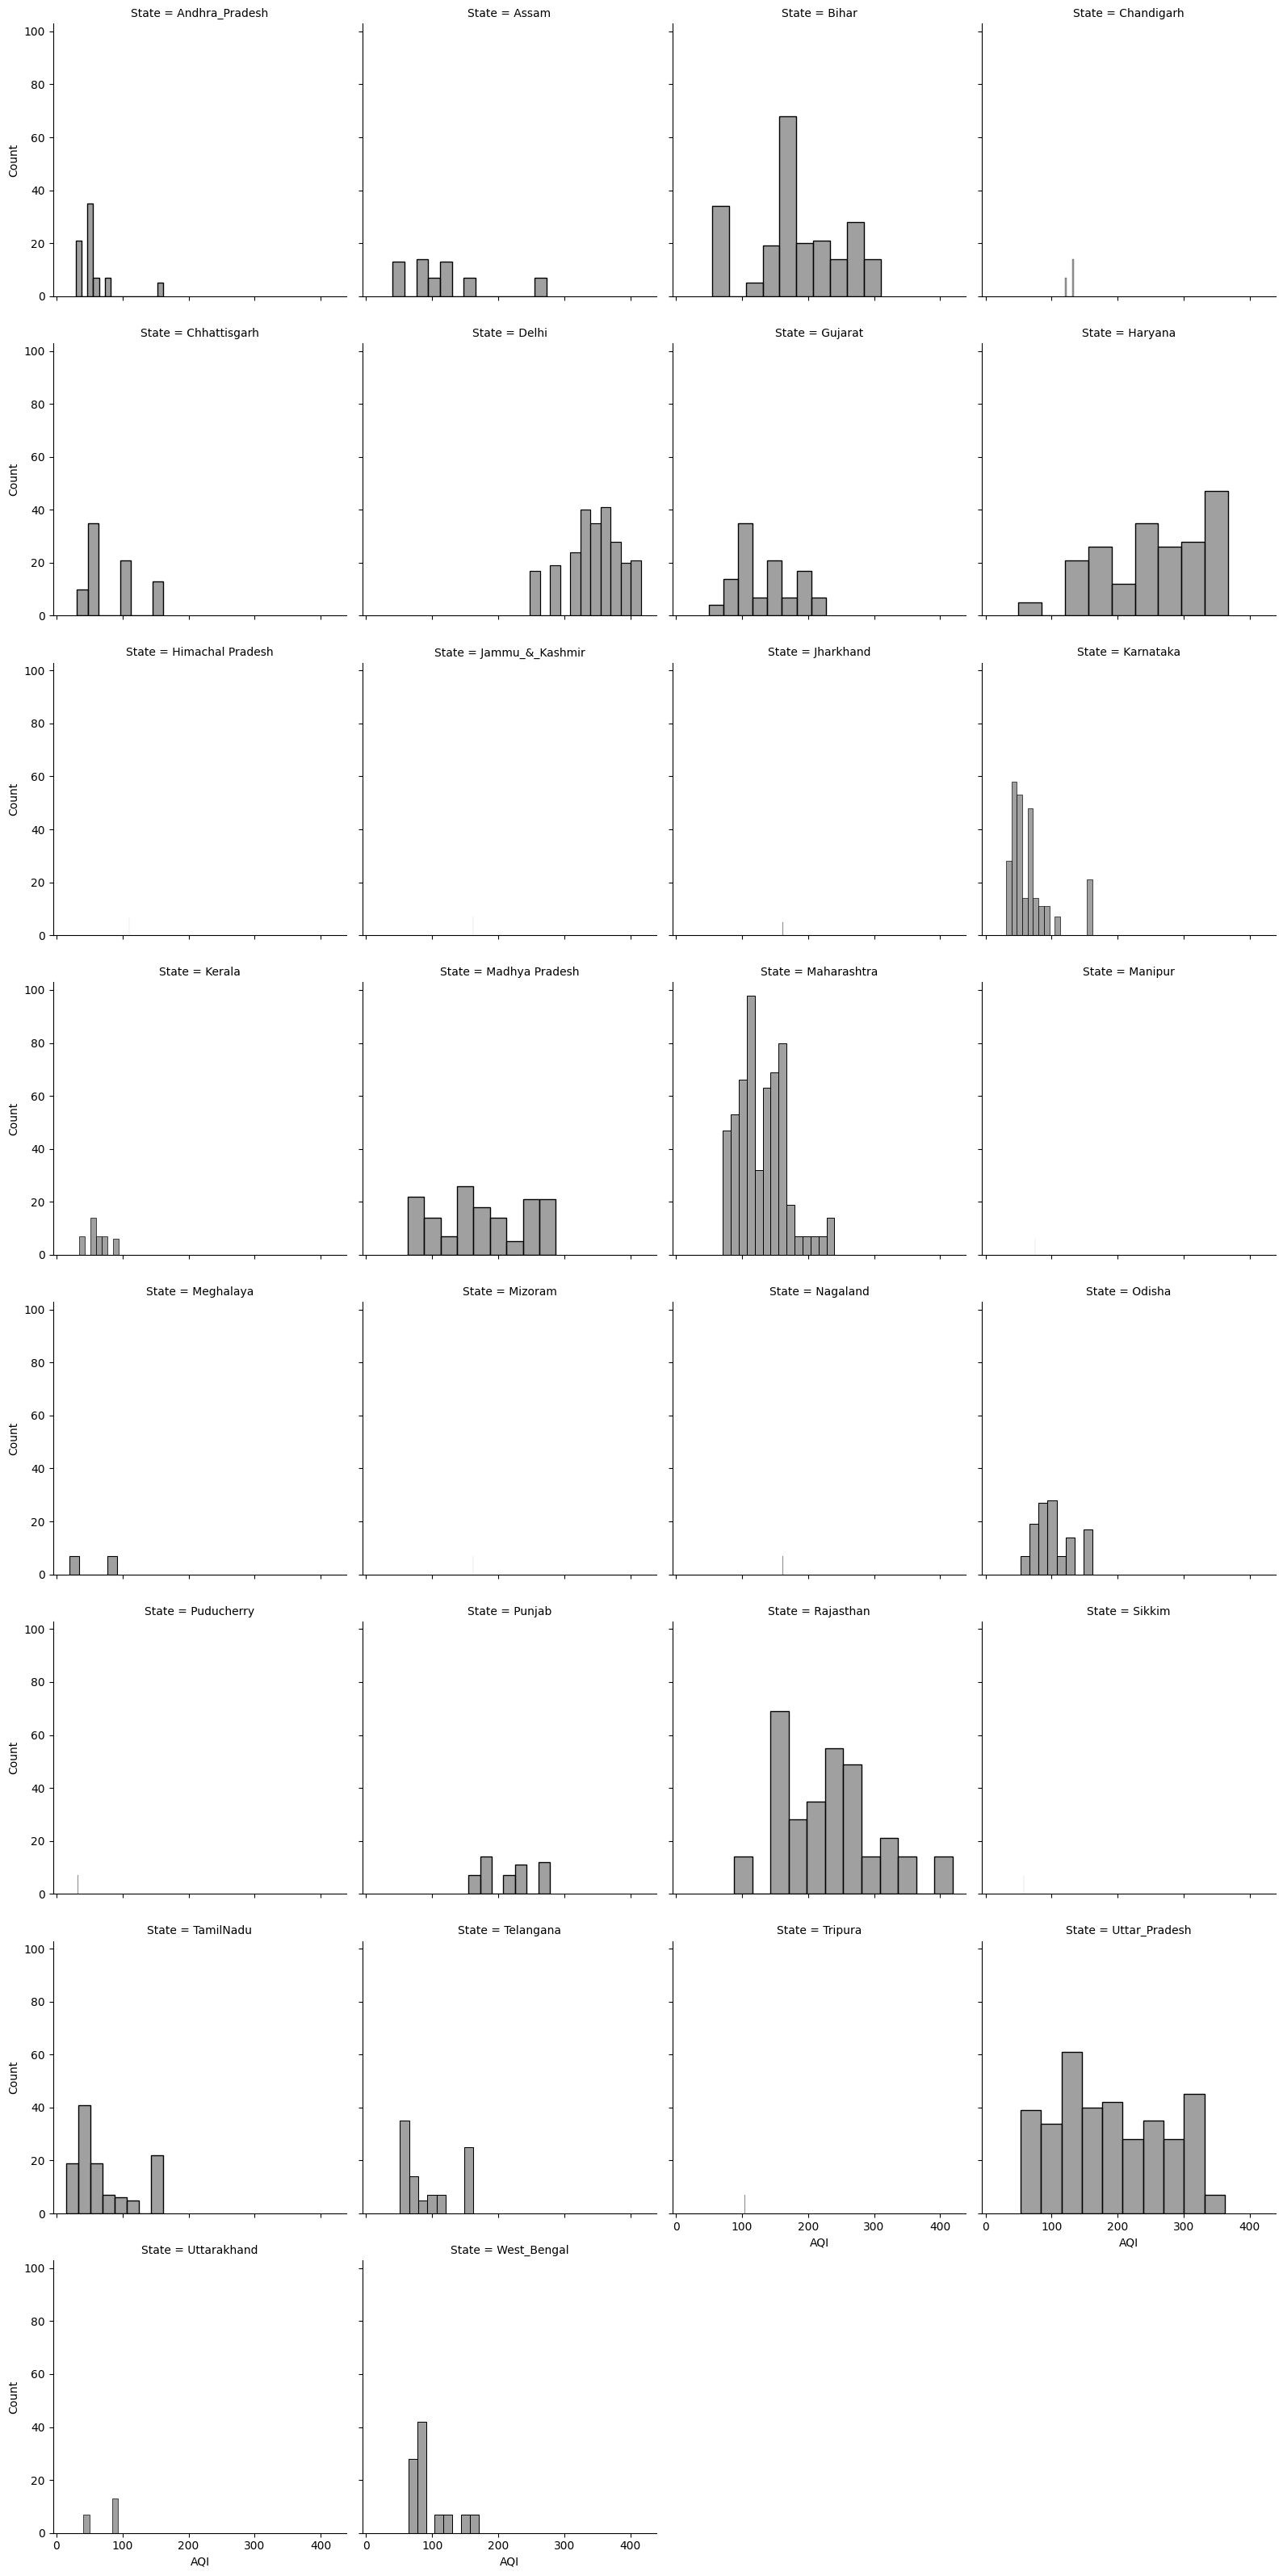

In [ ]:
g = sns.FacetGrid(df, col='State', col_wrap=4, height=4)
g.map(sns.histplot, 'AQI', color='grey') # Set the color to grey
plt.show()

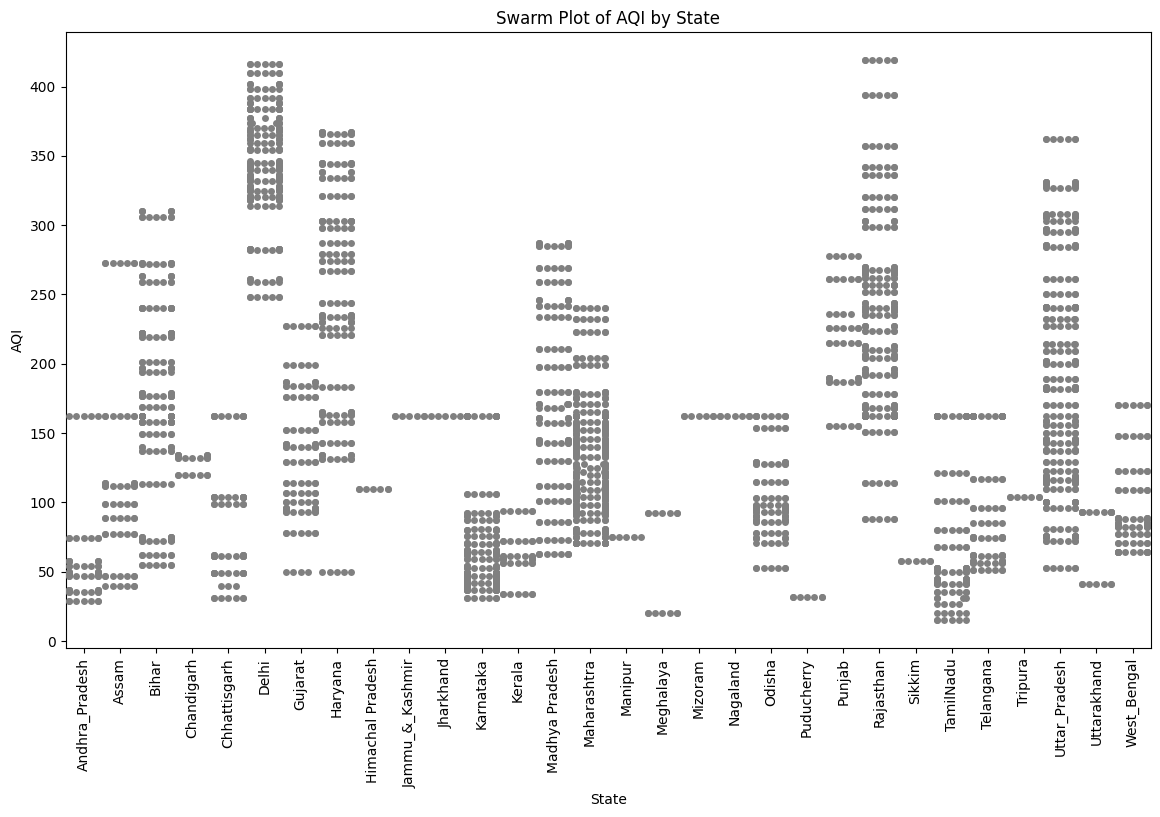

In [ ]:
plt.figure(figsize=(14, 8))
sns.swarmplot(x='State', y='AQI', data=df, color='grey')
plt.title('Swarm Plot of AQI by State')
plt.xlabel('State')
plt.ylabel('AQI')
plt.xticks(rotation=90)
plt.show()

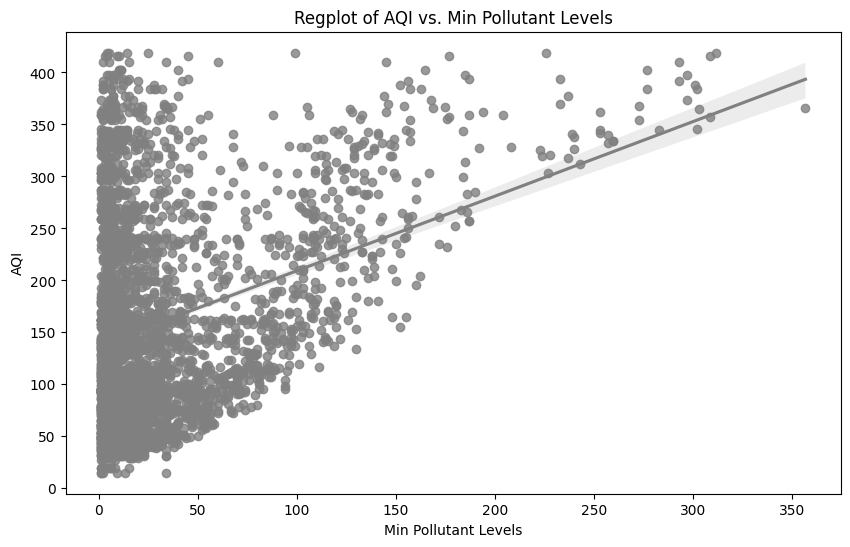

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Min', y='AQI', data=df,color='grey')
plt.title('Regplot of AQI vs. Min Pollutant Levels')
plt.xlabel('Min Pollutant Levels')
plt.ylabel('AQI')
plt.show()

<h2><b>Model</b></h2>

In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
numeric_columns = df_encoded.select_dtypes(include=['float64', 'int64']).columns
X = df_encoded.drop(columns=['AQI'])
y = df_encoded['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 23.22303851927788
R^2 Score: 0.9974837762405427


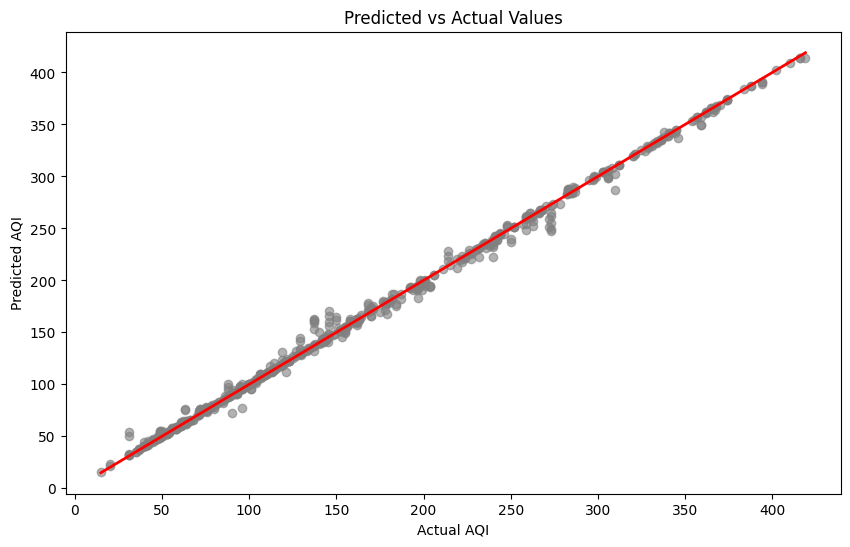

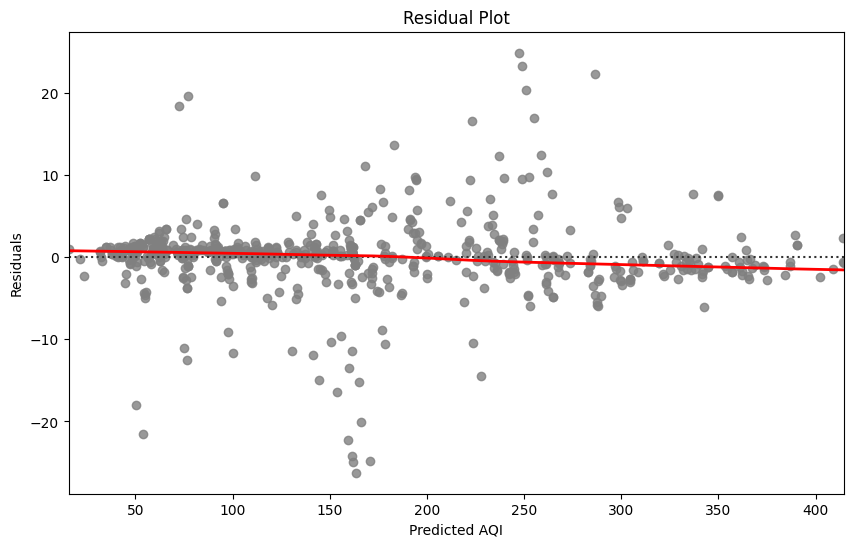

In [9]:
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='grey', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2) # Line for perfect prediction
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color="grey", line_kws={"color": "red", "lw": 2})
plt.title('Residual Plot')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals')
plt.show()